<a href="https://colab.research.google.com/github/willygru/hotel-revenue/blob/main/Hotel_Revenue_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install openpyxl
!pip install pandasql

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Import the libraries.
import sqlite3
import requests
import os
import pandas as pd
import pandasql as psql
from google.colab import files
import io
import json

In [ ]:
# Use files.upload to produce the "Choose Files" button below, then select your file.
uploaded = files.upload()

# Use io.BytesIO to decode the file, then json.load to open it.
file = io.BytesIO(uploaded['Hotel_report_secrets.json'])
credentials = json.load(file)

print(credentials)

In [4]:

url = "https://absentdata.com/wp-content/uploads/2021/05/hotel_revenue_historical_full-2.xlsx"

response = requests.get(url)

with open(os.path.join(credentials["PATH"], credentials["FILE_NAME"]), "wb") as f:
    f.write(response.content)

In [5]:
excel_file = os.path.join(credentials["PATH"], credentials["FILE_NAME"])
sheets_dict = pd.read_excel(excel_file, sheet_name=None)

In [6]:
df1 = sheets_dict['2018']
df2 = sheets_dict['2019']
df3 = sheets_dict['2020']
df4 = sheets_dict['meal_cost']
df5 = sheets_dict['market_segment']

In [7]:
df1.head(3)
# del df

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,1,85,2018,July,27,1,0,3,2,...,No Deposit,240.0,NaN,0,Transient,82.0,0,1,Canceled,2018-05-06
1,Resort Hotel,1,75,2018,July,27,1,0,3,2,...,No Deposit,15.0,NaN,0,Transient,105.5,0,0,Canceled,2018-04-22
2,Resort Hotel,1,23,2018,July,27,1,0,4,2,...,No Deposit,240.0,NaN,0,Transient,123.0,0,0,Canceled,2018-06-23


In [8]:
columns = df1.columns#.tolist()
print(columns)

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')


In [9]:
# conn = sqlite3.connect(':memory:')
conn = sqlite3.connect(credentials["PATH"] + 'hotel_database.db')


In [10]:
df1.to_sql('df1', conn, index=False, if_exists='replace')
df2.to_sql('df2', conn, index=False, if_exists='replace')
df3.to_sql('df3', conn, index=False, if_exists='replace')
df4.to_sql('df4', conn, index=False, if_exists='replace')
df5.to_sql('df5', conn, index=False, if_exists='replace')

8

In [11]:
def run_query(query):
  return pd.read_sql_query(query, conn)

In [12]:
query = """
WITH hotels as
(SELECT * FROM df1
UNION
SELECT * FROM df2
UNION
SELECT * FROM df3)
SELECT * FROM hotels
"""

result = run_query(query)
print(result)

               hotel  is_canceled  lead_time  arrival_date_year  \
0         City Hotel            0          0               2018   
1         City Hotel            0          0               2018   
2         City Hotel            0          0               2018   
3         City Hotel            0          0               2018   
4         City Hotel            0          0               2018   
...              ...          ...        ...                ...   
100751  Resort Hotel            1        468               2019   
100752  Resort Hotel            1        468               2019   
100753  Resort Hotel            1        468               2019   
100754  Resort Hotel            1        468               2019   
100755  Resort Hotel            1        471               2020   

       arrival_date_month  arrival_date_week_number  \
0                  August                        31   
1                  August                        32   
2                  August     

In [13]:
#Revenue here does not include discount 
query = """
WITH hotels as
(SELECT * FROM df1
UNION
SELECT * FROM df2
UNION
SELECT * FROM df3)

SELECT 
arrival_date_year,
hotel,
ROUND(SUM((stays_in_weekend_nights + stays_in_week_nights) * adr),1) as revenue  
FROM hotels
GROUP BY hotel, arrival_date_year
"""

result = run_query(query)
print(result)

   arrival_date_year         hotel     revenue
0               2018    City Hotel   1764667.6
1               2019    City Hotel  10755979.1
2               2020    City Hotel   8018122.4
3               2018  Resort Hotel   3120849.5
4               2019  Resort Hotel   9432430.3
5               2020  Resort Hotel   6266123.8


In [14]:
query = """
SELECT * FROM df5
"""

result = run_query(query)
print(result)

   Discount market_segment
0      0.00      Undefined
1      0.10         Direct
2      0.10         Groups
3      0.15      Corporate
4      0.20       Aviation
5      0.30  Offline TA/TO
6      0.30      Online TA
7      1.00  Complementary


In [15]:
query = """
WITH hotels as
(SELECT * FROM df1
UNION
SELECT * FROM df2
UNION
SELECT * FROM df3)

SELECT * FROM hotels
LEFT JOIN df5 
ON hotels.market_segment = df5.market_segment
"""

result = run_query(query)
print(result)

               hotel  is_canceled  lead_time  arrival_date_year  \
0         City Hotel            0          0               2018   
1         City Hotel            0          0               2018   
2         City Hotel            0          0               2018   
3         City Hotel            0          0               2018   
4         City Hotel            0          0               2018   
...              ...          ...        ...                ...   
100751  Resort Hotel            1        468               2019   
100752  Resort Hotel            1        468               2019   
100753  Resort Hotel            1        468               2019   
100754  Resort Hotel            1        468               2019   
100755  Resort Hotel            1        471               2020   

       arrival_date_month  arrival_date_week_number  \
0                  August                        31   
1                  August                        32   
2                  August     

In [16]:
query = """
WITH hotels as
(SELECT * FROM df1
UNION
SELECT * FROM df2
UNION
SELECT * FROM df3)

SELECT * FROM hotels
LEFT JOIN df5 
ON hotels.market_segment = df5.market_segment
"""

result = run_query(query)
columns = result.columns#.tolist()
print(columns)

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'Discount',
       'market_segment'],
      dtype='object')


In [17]:
query = """
WITH hotels as
(SELECT * FROM df1
UNION
SELECT * FROM df2
UNION
SELECT * FROM df3)

SELECT * FROM hotels
LEFT JOIN df5 
ON hotels.market_segment = df5.market_segment
"""

result = run_query(query)
# columns = result.columns#.tolist()
# print(columns)

desired_column = result[["market_segment", "Discount"]]
print(desired_column.isnull().any())

market_segment    False
market_segment    False
Discount          False
dtype: bool


In [18]:
query = """
SELECT * FROM df4
"""

result = run_query(query)
print(result)

    Cost       meal
0   0.00  Undefined
1  12.99         BB
2  17.99         HB
3  21.99         FB
4  35.00         SC


In [19]:
query = """
WITH hotels as
(SELECT * FROM df1
UNION
SELECT * FROM df2
UNION
SELECT * FROM df3)

SELECT * FROM hotels
LEFT JOIN df5 
ON hotels.market_segment = df5.market_segment
LEFT JOIN df4
ON hotels.meal = df4.meal
"""

result = run_query(query)
columns = result.columns#.tolist()
print(columns)

desired_column = result[["meal", "Cost"]]
print(desired_column.isnull().any())

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'Discount',
       'market_segment', 'Cost', 'meal'],
      dtype='object')
meal    False
meal    False
Cost    False
dtype: bool


**NOTE:** At this point, we will pull the information from our database into Power BI to create a visualization (report). Once the visualization is ready, we will pull it back into Google Colab for final presentation.

In [20]:
!pip install powerbiclient

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
from powerbiclient import Report, models
from powerbiclient.authentication import DeviceCodeLoginAuthentication
from google.colab import output

In [ ]:
# Import the DeviceCodeLoginAuthentication class to authenticate against Power BI and initiate the Micrsofot device authentication
device_auth = DeviceCodeLoginAuthentication()

In [ ]:
# Making sure we imported all required the libraries.
from google.colab import files
import io
import json

print(credentials)

In [24]:
group_id=credentials["GROUP_ID"] #THE POWER BI GROUP ID OR WORKSPACE ID
report_id=credentials["REPORT_ID"] #THE POWER BI REPORT ID

report = Report(group_id=group_id, report_id=report_id, auth=device_auth)
report.set_size(750, 1024)
output.enable_custom_widget_manager()

In [25]:
# Show the power BI report.
report

Report(container_height=750.0, container_width=1024.0)

Static image of report:

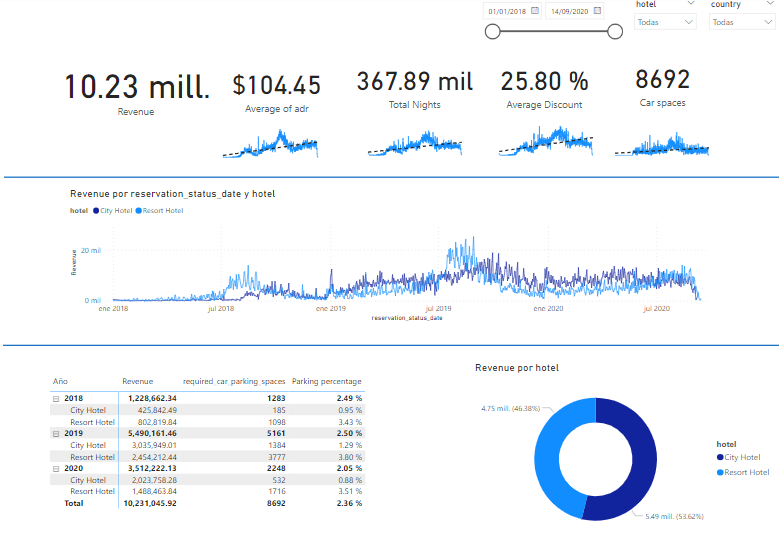